In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftn, ifftn
from scipy.signal import correlate2d

from opformer import TransformerOperator
import kernels

def GRF(alpha, beta, gamma, N, num_samples=10):
    xi = np.random.randn(num_samples, N, N)
    K1, K2 = np.meshgrid(np.arange(N), np.arange(N), indexing='ij')
    freq_sq = (K1**2 + K2**2)
    coef = alpha**0.5 * (4*np.pi**2 * freq_sq + beta)**(-gamma/2)
    L = N * coef * xi
    L[:, 0, 0] = 0  # enforce mean 0
    f_spatials = np.real(ifftn(L, norm='forward', axes=(-2, -1)))
    return f_spatials

def np_conv(kernel, img):
    kh, kw = kernel.shape
    H, W = img.shape

    # Compute asymmetric 'same' padding for even-sized kernels
    ph_top = kh // 2
    ph_bottom = kh - ph_top - 1
    pw_left = kw // 2
    pw_right = kw - pw_left - 1

    # Circular (wrap-around) padding
    padded = np.pad(
        img,
        ((ph_top, ph_bottom), (pw_left, pw_right)),
        mode='wrap'
    )

    # Perform cross-correlation (equivalent to conv2d with no flipping in PyTorch)
    # If you need strict convolution, flip the kernel:
    kernel_flipped = np.flip(kernel, axis=(0, 1))

    # Use 'valid' to get result of original size due to pre-padding
    result = correlate2d(padded, kernel_flipped, mode='valid')

    return result


def make_simple_learnable_operator_dataset(kx, ky, num_samples=25, H=64, W=64, sigma=1.0, seed=42):
    # Sample 5 random basis pairs (f_i, g_i)
    np.random.seed(seed)

    alpha, beta, gamma, N = 1.0, 1.0, 4.0, H
    num_bases = 1

    basis_fs = GRF(alpha, beta, gamma, N, num_bases)
    basis_gs = GRF(alpha, beta, gamma, N, num_bases)

    # Precompute convolutions (k * g_i)
    g_convs = np.array([np_conv(ky, g) for g in basis_gs])

    # Sample new input functions
    fs = GRF(alpha, beta, gamma, N, num_samples)

    # Compute operator outputs:
    # O(f) = sum_{i=1}^5 <f, f_i> * (k * g_i)
    Ofs = np.zeros((num_samples, H, W))
    for j in range(num_samples):
        for i in range(num_bases):
            inner = kx(fs[j], basis_fs[i])
            Ofs[j] += inner * g_convs[i]

    return fs, Ofs

In [ ]:
import torch

device = "cuda"
im_size = (64, 64)

def construct_Z(f_test, Of, f):
    f_full = np.concatenate([f[:-1], np.expand_dims(f_test, axis=0)], axis=0)
    Z = np.expand_dims(np.concatenate([f_full, Of], axis=1), axis=0)
    Z_pt = torch.from_numpy(Z).to(device).to(torch.float32)
    Z_pt[:,-1,im_size[0]:] = 0
    return Z_pt
    
H, W = 64, 64
kernel_maps = kernels.Kernels(H, W)

kx_names = ['linear', 'polynomial', 'laplacian', 'sobolev', 'fourier', 'gradient_rbf', 'energy']
kx_name_true = "energy"
kx_true = kernels.get_kx_kernel(kx_name_true)
ky_true = kernel_maps.get_kernel("gaussian")

num_samples = 25
f, Of = make_simple_learnable_operator_dataset(
    kx_true, ky_true, num_samples=num_samples
)

f_train  = f[:-1]
Of_train = Of[:-1]
f_test   = f[-1]
Of_test  = Of[-1]

# y_idx  = -1
Z_test = construct_Z(f_test, Of, f)

kernel_to_preds, kernel_to_errors = {}, {}
# for kernel_name in ["uniform"]:
for kx_name in kx_names:
    r = .01 # 5e-1
    num_layers = 250
    opformer = TransformerOperator(num_layers=num_layers, im_size=im_size, kernel=ky_true, kx_name=kx_name, icl_lr=-r, icl_init=True).to(device)

    _, preds = opformer(Z_test)
    test_preds = np.array([pred[0,-1,64:,:,0] for pred in preds]) # just extract bottom right for test prediction
    errors = np.array([np.linalg.norm(test_pred + Of_test) for test_pred in test_preds])

    kernel_to_preds[kx_name]  = test_preds
    kernel_to_errors[kx_name] = errors

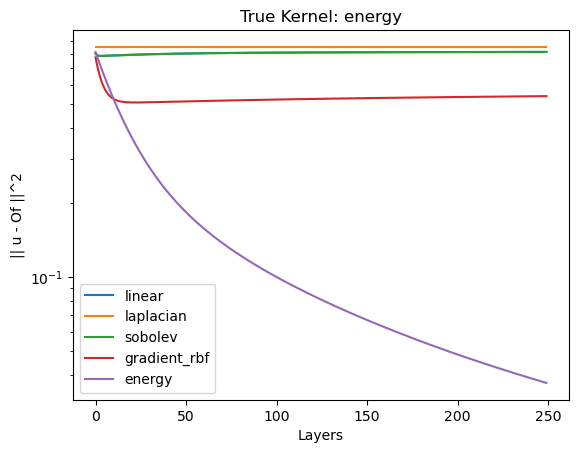

In [13]:
plt.title(f"True Kernel: {kx_name_true}")
plt.xlabel("Layers")
plt.ylabel("|| u - Of ||^2")

for kernel_name in kernel_to_preds:
    if np.isfinite(kernel_to_errors[kernel_name][-1]):
        plt.semilogy(kernel_to_errors[kernel_name], label=kernel_name)
    
plt.legend()
plt.savefig(f"{kx_name_true}.png")

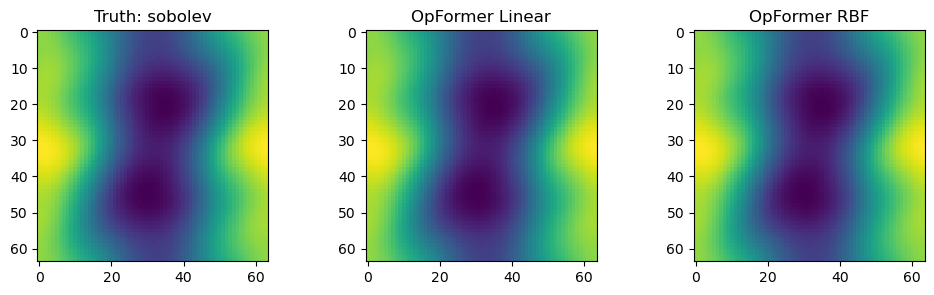

In [57]:
fig, axs = plt.subplots(1,3,figsize=(12,3))

axs[0].set_title(f"Truth: {kx_name_true}")
axs[0].imshow(Of[y_idx])

axs[1].set_title(f"OpFormer Linear")
axs[1].imshow(-kernel_to_preds["linear"][-1])

axs[2].set_title(f"OpFormer RBF")
axs[2].imshow(-kernel_to_preds["rbf"][-1])

In [ ]:

# manual GD used for debugging
# Precompute inner products <f_train[i], f_train[j]>
errors   = {}
for kx_name in kx_names:
    T, H, W = f_train.shape

    kx_test = get_kx_kernel(kx_name)
    gram = np.array([
        [kx_test(f_train[i], f_train[j]) for j in range(T)]
        for i in range(T)
    ])

    # Flatten training outputs
    Y = Of_train.reshape(T, -1)  # shape (T, H*W)

    # Solve G alpha = Y for each pixel
    alpha = np.linalg.solve(gram, Y)  # shape (T, H*W)

    test_inner_prods = np.array([kx_test(f_test, f_train[i]) for i in range(T)])  # shape (T,)
    
    kx = np.zeros((T+1,T+1))
    kx[:-1,:-1] = gram
    kx[:-1,-1]  = test_inner_prods
    kx = np.expand_dims(kx, axis=0)
    np.save(f"kx_{kx_name}.npy", kx)
    
    Of_test_pred_flat = (test_inner_prods @ alpha).reshape(H, W)  # shape (H*W,)
    errors[kx_name] = np.linalg.norm(Of_test - Of_test_pred_flat)

for kx_name in errors:
    print(f"{kx_name} -- {errors[kx_name]}")

In [ ]:

# manual GD used for debugging
# Precompute inner products <f_train[i], f_train[j]>
errors   = {}
for kx_name in kx_names:
    T, H, W = f_train.shape

    kx_test = get_kx_kernel(kx_name)
    gram = np.array([
        [kx_test(f_train[i], f_train[j]) for j in range(T)]
        for i in range(T)
    ])

    # Flatten training outputs
    Y = Of_train.reshape(T, -1)  # shape (T, H*W)

    # Solve G alpha = Y for each pixel
    alpha = np.linalg.solve(gram, Y)  # shape (T, H*W)

    test_inner_prods = np.array([kx_test(f_test, f_train[i]) for i in range(T)])  # shape (T,)
    
    kx = np.zeros((T+1,T+1))
    kx[:-1,:-1] = gram
    kx[:-1,-1]  = test_inner_prods
    kx = np.expand_dims(kx, axis=0)
    np.save(f"kx_{kx_name}.npy", kx)
    
    Of_test_pred_flat = (test_inner_prods @ alpha).reshape(H, W)  # shape (H*W,)
    errors[kx_name] = np.linalg.norm(Of_test - Of_test_pred_flat)

for kx_name in errors:
    print(f"{kx_name} -- {errors[kx_name]}")

In [17]:
for layer_idx in range(num_layers):
    # Check if y^i_l+1 = y_l + TF_l(x^i)
    pred = preds[layer_idx][0,...,0]
    y_i    = pred[y_idx,64:]
    y_pred = pred[-1,64:]

    print(f"y {y_idx} | Layer {layer_idx} -- {np.isclose(Of[y_idx] + y_pred, y_i).all()}")

    # Check if y^i_l+1 = y^i_l + \sum_j y^j_l h(x^j, x)
    delta = np.zeros(Of[y_idx].shape)
    if layer_idx == 0:
        prev_layer = Of
    else:
        prev_layer = preds[layer_idx-1][0,:,64:,:,0]
    
    for i in range(icl_num_samples-1):
        kxx   = np.sum(f[i] * f[y_idx]) / (64 * 64)
        ly    = -r * np_conv(kernels[true_kernel_name], prev_layer[i])
        delta += kxx * ly

    exp_y = prev_layer[y_idx] + delta

    print(f"y = y + \sum_i y_i h(x_i, x) -- {np.isclose(exp_y, y_i).all()}")
print("----------------------------------")

y 0 | Layer 0 -- True
y = y + \sum_i y_i h(x_i, x) -- False
y 0 | Layer 1 -- True
y = y + \sum_i y_i h(x_i, x) -- False
y 0 | Layer 2 -- True
y = y + \sum_i y_i h(x_i, x) -- False
y 0 | Layer 3 -- True
y = y + \sum_i y_i h(x_i, x) -- False
y 0 | Layer 4 -- True
y = y + \sum_i y_i h(x_i, x) -- False
y 0 | Layer 5 -- True
y = y + \sum_i y_i h(x_i, x) -- False
y 0 | Layer 6 -- True
y = y + \sum_i y_i h(x_i, x) -- False
y 0 | Layer 7 -- True
y = y + \sum_i y_i h(x_i, x) -- False
y 0 | Layer 8 -- True
y = y + \sum_i y_i h(x_i, x) -- False
y 0 | Layer 9 -- True
y = y + \sum_i y_i h(x_i, x) -- False
y 0 | Layer 10 -- True
y = y + \sum_i y_i h(x_i, x) -- False
y 0 | Layer 11 -- True
y = y + \sum_i y_i h(x_i, x) -- False
y 0 | Layer 12 -- True
y = y + \sum_i y_i h(x_i, x) -- False
y 0 | Layer 13 -- True
y = y + \sum_i y_i h(x_i, x) -- False
y 0 | Layer 14 -- True
y = y + \sum_i y_i h(x_i, x) -- False
y 0 | Layer 15 -- True
y = y + \sum_i y_i h(x_i, x) -- False
y 0 | Layer 16 -- True
y = y + \su

In [79]:
v = np.load("v.npy")
kx = np.load("kx.npy")

In [81]:
kx.shape

(1, 2, 2)

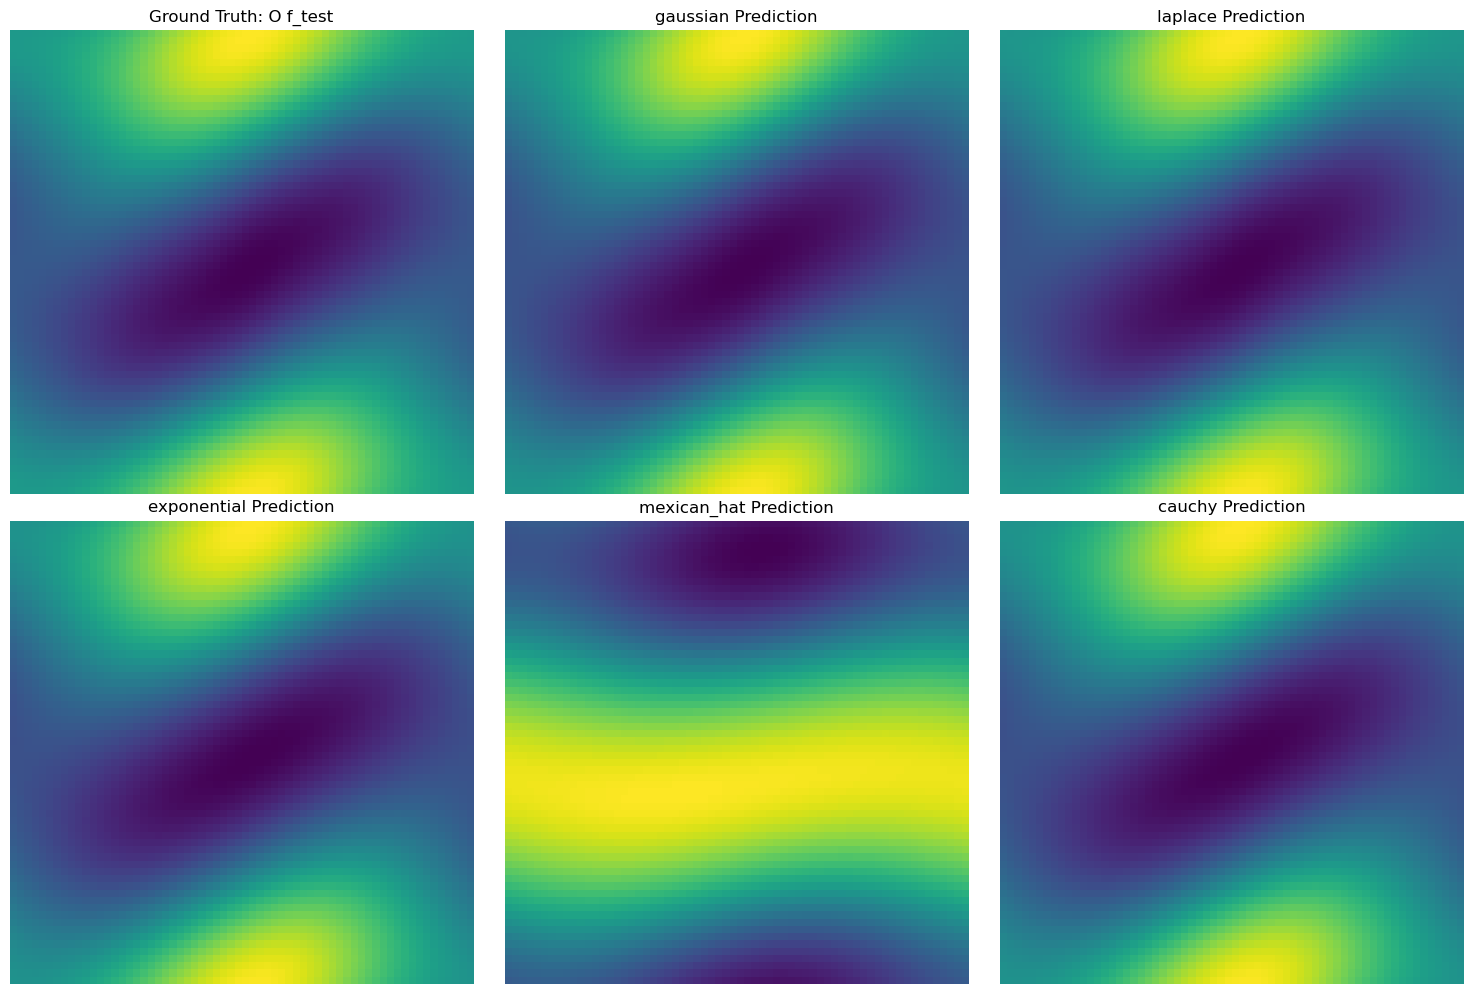

In [60]:
# Plot comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0,0].imshow(Of[y_idx], cmap='viridis')
axes[0,0].set_title("Ground Truth: O f_test")
axes[0,0].axis('off')

for i, kernel_name in enumerate(kernels):
    row, col = divmod(i+1, 3)

    axes[row, col].imshow(-kernel_to_preds[kernel_name][-1], cmap='viridis')
    axes[row, col].set_title(f"{kernel_name} Prediction")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

y 3 | Layer 0 -- True
y = y + \sum_i y_i h(x_i, x) -- False
y 3 | Layer 1 -- True
y = y + \sum_i y_i h(x_i, x) -- False
y 3 | Layer 2 -- True


KeyboardInterrupt: 

In [5]:
import torch.nn.functional as F

def pt_conv(kernel, img):
    # Compute asymmetric 'same' padding for even-sized kernels
    _, _, kh, kw = kernel.shape
    ph_top = kh // 2
    ph_bottom = kh - ph_top - 1
    pw_left = kw // 2
    pw_right = kw - pw_left - 1

    # Apply circular padding manually
    value_padded = F.pad(
        img.unsqueeze(0),  # [1, H, W]
        (pw_left, pw_right, ph_top, ph_bottom),  # (L, R, T, B)
        mode='circular'
    )
    
    return F.conv2d(
        value_padded.unsqueeze(0),
        kernel,  # [1, 1, kh, kw]
        padding=0,
    )

In [12]:
kernel            = kernel_maps.get_kernel("gaussian")
pt_conv_result    = pt_conv(torch.from_numpy(true_kernel).unsqueeze(0).unsqueeze(0), torch.from_numpy(Of[y_idx]))
pt_conv_result_np = r * pt_conv_result[0,0].cpu().detach().numpy()

In [ ]:
import torch.nn.functional as F

def pt_conv(kernel, img):
    # Compute asymmetric 'same' padding for even-sized kernels
    _, _, kh, kw = kernel.shape
    ph_top = kh // 2
    ph_bottom = kh - ph_top - 1
    pw_left = kw // 2
    pw_right = kw - pw_left - 1

    # Apply circular padding manually
    value_padded = F.pad(
        img.unsqueeze(0),  # [1, H, W]
        (pw_left, pw_right, ph_top, ph_bottom),  # (L, R, T, B)
        mode='circular'
    )
    
    return F.conv2d(
        value_padded.unsqueeze(0),
        kernel,  # [1, 1, kh, kw]
        padding=0,
    )

In [ ]:

def construct_Z(f_test):
    f_full = np.concatenate([f[:-1], np.expand_dims(f_test, axis=0)], axis=0)
    Z = np.expand_dims(np.concatenate([f_full, Of], axis=1), axis=0)
    Z_pt = torch.from_numpy(Z).to(device).to(torch.float32)
    Z_pt[:,-1,im_size[0]:] = 0
    return Z_pt

device = "cuda"
im_size = (64, 64)

Z_pt = construct_Z(f_test)

kernel_names = kernel_maps.available_kernels()
kernel_to_preds, kernel_to_errors = {}, {}
for kernel_name in [kernel_names[0]]:
    opformer = TransformerOperator(num_layers=350, im_size=im_size, kernel=kernel_maps.get_kernel(kernel_name), icl_lr=5e-2, icl_init=True).to(device)
    _, preds = opformer(Z_pt)

    kernel_to_preds[kernel_name]  = np.array([pred[0,-1,64:,:,0] for pred in preds]) # just extract bottom right for test prediction
    kernel_to_errors[kernel_name] = np.array([np.sum((test_pred - Of_test) ** 2) for test_pred in kernel_to_preds[kernel_name]])

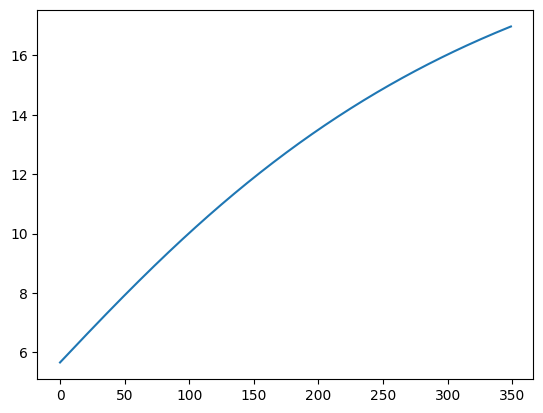

In [14]:
plt.plot(kernel_to_errors["gaussian"])

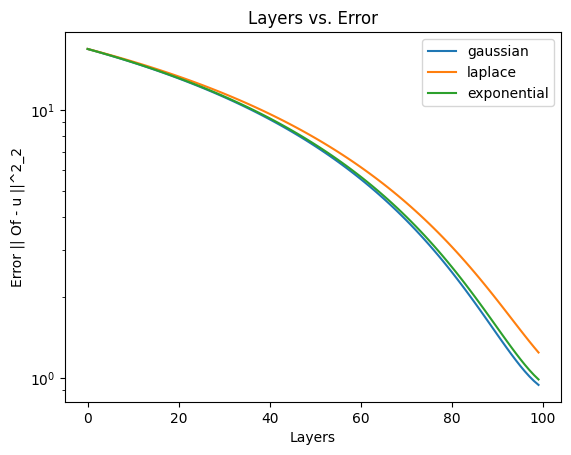

In [7]:
for kernel_name in kernel_to_errors:
    plt.semilogy(kernel_to_errors[kernel_name], label=kernel_name)

plt.xlabel("Layers")
plt.ylabel("Error || Of - u ||^2_2")
plt.title("Layers vs. Error")
plt.legend()

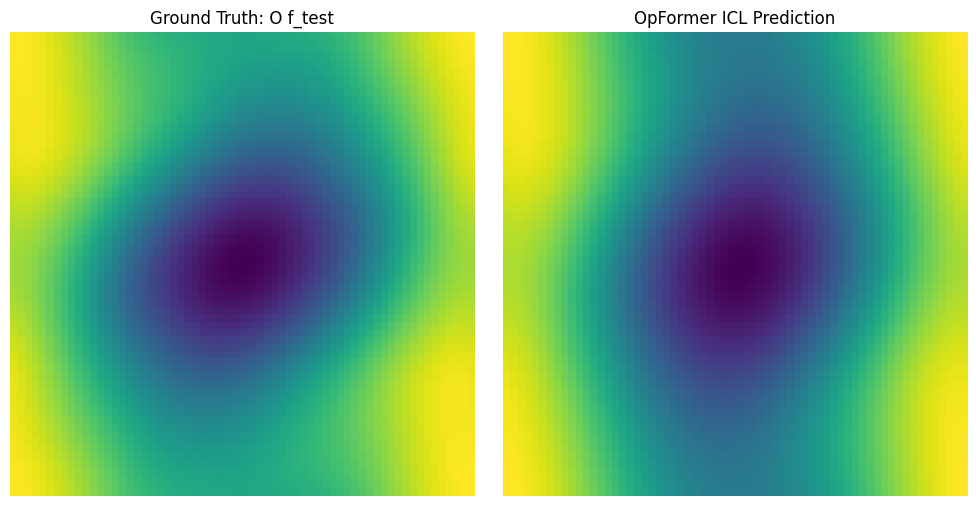

(None, np.float64(120.46352620544961))

In [8]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(Of_test, cmap='viridis')
axes[0].set_title("Ground Truth: O f_test")
axes[0].axis('off')

axes[1].imshow(kernel_to_preds["laplace"][-1,0], cmap='viridis')
axes[1].set_title("OpFormer ICL Prediction")
axes[1].axis('off')

plt.tight_layout()
plt.show(), losses[-1]

# Debugging

In [8]:
import torch

def construct_Z(f_test):
    f_full = np.concatenate([f[:-1], np.expand_dims(f_test, axis=0)], axis=0)
    Z = np.expand_dims(np.concatenate([f_full, Of], axis=1), axis=0)
    Z_pt = torch.from_numpy(Z).to(device).to(torch.float32)
    Z_pt[:,-1,im_size[0]:] = 0
    return Z_pt

r = 1e-1
num_layers = 10

opformer = TransformerOperator(num_layers=num_layers, im_size=im_size, kernel=kernel_maps.get_kernel(kernel_name), icl_lr=r, icl_init=True).to(device)

y_idx = 0

for y_idx in [0,1,2]:
    Z_test = construct_Z(f[y_idx])

    # confirm setup
    for i in range(Z_test.shape[1]-1):
        print(f"x same: {np.isclose(Z_test[0,i,:64].cpu().detach().numpy(),  f[i]).all()}")
        print(f"y same: {np.isclose(Z_test[0,i,64:].cpu().detach().numpy(), Of[i]).all()}")
    
    print(f"y test set: {np.isclose(Z_test[0,-1,:64].cpu().detach().numpy(), f[y_idx]).all()}")
    print(f"y test zeroed: {(Z_test[0,-1,64:].cpu().detach().numpy() == 0).all()}")

    _, preds = opformer(Z_test)

    for layer_idx in range(num_layers):
        pred = preds[layer_idx][0,...,0]
        y_i    = pred[y_idx,64:]
        y_pred = pred[-1,64:]

        print(f"y {y_idx} | Layer {layer_idx} -- {np.isclose(Of[y_idx] + y_pred, y_i).all()}")
    print("---------------------------")

x same: True
y same: True
x same: True
y same: True
x same: True
y same: True
x same: True
y same: True
y test set: True
y test zeroed: True
y 0 | Layer 0 -- True
y 0 | Layer 1 -- True
y 0 | Layer 2 -- True
y 0 | Layer 3 -- True
y 0 | Layer 4 -- True
y 0 | Layer 5 -- True
y 0 | Layer 6 -- True
y 0 | Layer 7 -- True
y 0 | Layer 8 -- True
y 0 | Layer 9 -- True
---------------------------
x same: True
y same: True
x same: True
y same: True
x same: True
y same: True
x same: True
y same: True
y test set: True
y test zeroed: True
y 1 | Layer 0 -- True
y 1 | Layer 1 -- True
y 1 | Layer 2 -- True
y 1 | Layer 3 -- True
y 1 | Layer 4 -- True
y 1 | Layer 5 -- True
y 1 | Layer 6 -- True
y 1 | Layer 7 -- True
y 1 | Layer 8 -- True
y 1 | Layer 9 -- True
---------------------------
x same: True
y same: True
x same: True
y same: True
x same: True
y same: True
x same: True
y same: True
y test set: True
y test zeroed: True
y 2 | Layer 0 -- True
y 2 | Layer 1 -- True
y 2 | Layer 2 -- True
y 2 | Layer 3 -

In [9]:
import numpy as np

a = np.load("a.npy")
b = np.load("b.npy")

a_v = np.load("a_v.npy")
b_v = np.load("b_v.npy")

In [16]:
np.linalg.norm(a)

11.745013

In [7]:
a[~np.isclose(a, b)]

array([ 3.2418221e-04,  1.5511923e-04, -4.6145171e-05, -4.6141446e-05,
       -4.2859465e-04,  9.2590973e-04, -2.9860996e-04, -5.4363906e-04,
       -4.3264031e-04,  5.9701502e-05,  5.9060752e-05, -7.2453171e-05,
        9.2514977e-04,  5.6285039e-04, -1.6491674e-04, -2.0604022e-04,
        6.4839423e-04,  2.0010024e-04,  1.4078245e-04,  1.0221601e-03,
        8.2219020e-04, -1.2232065e-03, -6.0874596e-04, -1.1545494e-03,
       -6.0873479e-04, -1.3120733e-03], dtype=float32)

In [2]:
print(a)

[[[[[ 0.04423453]
    [ 0.04413269]
    [ 0.04383287]
    ...
    [ 0.0433538 ]
    [ 0.04383287]
    [ 0.04413269]]

   [[ 0.0441457 ]
    [ 0.04402249]
    [ 0.0437047 ]
    ...
    [ 0.04331645]
    [ 0.04377877]
    [ 0.04406249]]

   [[ 0.04387739]
    [ 0.04372955]
    [ 0.04338523]
    ...
    [ 0.04310408]
    [ 0.04355562]
    [ 0.0438188 ]]

   ...

   [[ 0.04343414]
    [ 0.04340628]
    [ 0.04316998]
    ...
    [ 0.04231132]
    [ 0.04287312]
    [ 0.04325388]]

   [[ 0.04387739]
    [ 0.04381881]
    [ 0.04355562]
    ...
    [ 0.04285505]
    [ 0.04338524]
    [ 0.04372955]]

   [[ 0.0441457 ]
    [ 0.04406249]
    [ 0.04377877]
    ...
    [ 0.04320278]
    [ 0.0437047 ]
    [ 0.04402249]]]


  [[[-0.11935653]
    [-0.11925869]
    [-0.11895343]
    ...
    [-0.1184328 ]
    [-0.11895342]
    [-0.11925869]]

   [[-0.11886275]
    [-0.11880095]
    [-0.11853058]
    ...
    [-0.11782072]
    [-0.11837444]
    [-0.11871891]]

   [[-0.11738335]
    [-0.11735028]
    [-0.11